# Downstream Analysis - Python

Now for the fun bit, wrangling the data and plotting our results! Below, we do this using pandas, matplotlib and statsmodels, and some convenience functions from `py_clone_detective.clone_analysis`.

First, we read in results previously generated by py_clone_detector:

In [ ]:
import pandas as pd

df = pd.read_csv('data/example_results.csv')

df.head()

,int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,...,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,2196457.0,True,False,False,False,False
1,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,52757.0,True,False,False,False,False
2,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,2262648.0,True,False,False,False,False
3,a1g01p1,11,0,2,2,4,1,3,4,0,...,89.552116,0.440881,73.280625,False,67331.0,True,False,False,False,False
4,a1g01p1,12,0,4,0,4,1,3,4,0,...,486.798467,0.465227,98.690625,False,4113516.0,True,False,False,False,False


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
count_df = df.query('int_img_ch == "C1"').filter(regex=r"clone$|pos$|int_img")

Next, we groupby clones per image and sum to get the number of cells of each type per clone.

In [ ]:
count_df = count_df.groupby(["int_img", "GFP_clone"]).sum().reset_index()
count_df.head()

,int_img,GFP_clone,GFP_clonepos,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
0,a1g01p1,0,0,70,2,4,98,1
1,a1g01p1,1,14,9,0,0,5,0
2,a1g01p1,2,1,0,0,0,1,0
3,a1g01p1,3,4,1,0,0,3,0
4,a1g01p1,4,34,12,0,1,21,0


We can add a sum all cell types per clone to get an additional 'total' column:

In [ ]:
import re
# drop the unneeded "GFP column"
count_df = count_df.drop(columns="GFP_clonepos")

# calculate the total cells
count_df['total'] = count_df.filter(regex='_pos').sum(axis=1)

# simplify column names
count_df.columns = [re.sub("_pos", "", col) for col in count_df.columns]

Since where "GFP_clone" == 0, we can add an additional column stating whether a "GFP_clone" is inside a clone (*IC*) or outside a clone (*OC*):

In [ ]:
import numpy as np

count_df["clone_status"] = np.where(count_df["GFP_clone"] == 0, "OC", "IC")

Finally, the images are named 'a1' if from a wild-type (*ctrl*) animal and 'a2' if from a mutant (*mut*) animal. We can therefore add a 'genotype' column:

In [ ]:
count_df["genotype"] = np.where(count_df["int_img"].str.match(r"a1"), "ctrl", "mut")

We can groupby this genotype column and generate a stacked bar plot displaying cell numbers and types per clone. Here, we only interested in plotting cells inside clones, and so we first query on 'clone_status':

In [ ]:
count_df_inside = count_df.query('clone_status == "IC"')

inside_clone_mean = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .mean()
)

inside_clone_sem = (
    count_df_inside[["genotype", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby("genotype")
    .sem()
)

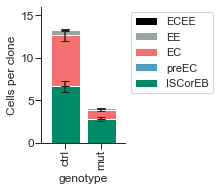

In [ ]:
import py_clone_detective.clone_analysis as ca

ca.create_stack_bar_plot(
    inside_clone_mean,
    inside_clone_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
    bar_width=0.8,
    y_axis_limit=16,
    y_label="Cells per clone",
)

From this plot we can see that 'mutant' clones are on average bigger than 'ctrl' clones. This suggests that the mutation in our gene of interest may affect **cell proliferation**. Let do a t-test using the statsmodels library to see if this difference is significant:

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
lm = ols("total ~ genotype", data=count_df_inside).fit()
lm.t_test_pairwise("genotype").result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
mut-ctrl,-9.296581,1.257855,-7.390821,7.756635e-13,-11.76894,-6.824223,7.757128e-13,True


Yes, the total number of cell per clone is significantly different in "ctrl" vs "mutant" animals. 

## Cell Differentiation - percentage cell type inside and outside clones

Next, let's investigate whether the types of cells inside and outside clones are different in ctrl and mutant animals. This information will help us determine whether our gene of interest affects **cell differentiation**.

First, since we already know that 'mutant' clones possess fewer cells than 'ctrl' clones, it is helpful to summarise cell types as a percentage.

In [ ]:
percentage_df = count_df.eval(
    """EC = EC / total * 100 
    EE = EE / total * 100
    ECEE = ECEE / total * 100 
    preEC = preEC / total * 100 
    ISCorEB = ISCorEB / total * 100"""
)

Next, we plot a stacked barplot as before. However, this time we plot percentage cell types:

In [ ]:
percentage_df_mean = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .mean()
)

percentage_df_sem = (
    percentage_df[["genotype", "clone_status", "ISCorEB", "preEC", "EC", "EE", "ECEE"]]
    .groupby(["clone_status", "genotype"])
    .sem()
)

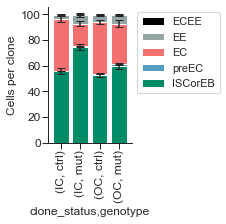

In [ ]:
ca.create_stack_bar_plot(
    percentage_df_mean,
    percentage_df_sem,
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6", "#000000"],
    bar_width=0.8,
    y_label="Cells per clone",
)

This plot suggests there might be a difference in percentage cell-types of mutant clones vs ctrl. Let's check if these differences are statistically significant.

To do this, we reshape our percentage data into a tidy format:

In [ ]:
tidy_percentage_df = pd.melt(
    percentage_df,
    id_vars=["genotype", "clone_status"],
    value_vars=["ISCorEB", "preEC", "EC", "EE", "ECEE"],
    var_name="cell_type",
    value_name="perc_cell_num",
)
tidy_percentage_df.head()

,genotype,clone_status,cell_type,perc_cell_num
0,ctrl,OC,ISCorEB,56.000000
1,ctrl,IC,ISCorEB,35.714286
2,ctrl,IC,ISCorEB,100.000000
3,ctrl,IC,ISCorEB,75.000000
4,ctrl,IC,ISCorEB,61.764706


We then create a composite column that contains genotype (g), clone_status (cs) and cell_type (ct) information.

In [ ]:
tidy_percentage_df["comp_g_cs_ct"] = (
    tidy_percentage_df["genotype"]
    + "_"
    + tidy_percentage_df["clone_status"]
    + "_"
    + tidy_percentage_df["cell_type"]
)
tidy_percentage_df.head()

tidy_percentage_df["comp_g_cs_ct"] = tidy_percentage_df["comp_g_cs_ct"].astype(
    "category"
)

Using statsmodels and patsy, we set up a ContrastMatrix for our desired comparisons.

Our first set of contrasts compares the percentage of each cell type <u>inside mutant vs ctrl</u> clones:

In [ ]:
contrasts = [
    "mut_IC_EC-ctrl_IC_EC",
    "mut_IC_EE-ctrl_IC_EE",
    "mut_IC_preEC-ctrl_IC_preEC",
    "mut_IC_ISCorEB-ctrl_IC_ISCorEB",
    "mut_IC_ECEE-ctrl_IC_ECEE"
]

We would also like to compare the percentage of each cell type <u>outside mutant vs inside mutant</u> clones.

In [ ]:
contrasts = [
    "mut_OC_EC-mut_IC_EC",
    "mut_OC_EE-mut_IC_EE",
    "mut_OC_preEC-mut_IC_preEC",
    "mut_OC_ISCorEB-mut_IC_ISCorEB",
    "mut_OC_ECEE-mut_IC_ECEE"
] + contrasts

Below is a helper function to construct the values of contrast matrix:

In [ ]:
def create_contrast_matrix(desired_contrasts, df_column):
    l = list()
    levels = pd.Series(df_column.cat.categories.values)
    for contrast in desired_contrasts:
        group_A, group_B = contrast.split("-")
        l.append(levels.replace({group_A: -1, group_B: 1, ".": 0}, regex=True))
    return np.stack(l, axis=1)

We can now setup a custom contrast matrix using patsy:

In [ ]:
matrix = create_contrast_matrix(contrasts, tidy_percentage_df["comp_g_cs_ct"])

from patsy.contrasts import ContrastMatrix

c_matrix = ContrastMatrix(matrix=matrix, column_suffixes=contrasts)
c_matrix

ContrastMatrix(array([[ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  1],
                      [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 1,  0,  0,  0,  0, -1,  0,  0,  0,  0],
                      [ 1,  0,  0,  0,  1, -1,  0,  0,  0, -1],
                      [ 0,  1,  0,  0,  0,  0, -1,  0,  0,  0],
                      [ 0,  0,  0,  1,  0,  0,  0,  0, -1,  0],
                      [ 0,  0,  1,  0,  0,  0,  0, -1,  0,  0],
                      [-1,  0,  0,  0,  

Finally, we construct a 'ordinary least squares' (ols) model using statsmodels and test our desired contrasts:

In [ ]:
lm = ols("perc_cell_num ~ 0 + C(comp_g_cs_ct, c_matrix)", data=tidy_percentage_df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          perc_cell_num   R-squared (uncentered):                   0.371
Model:                            OLS   Adj. R-squared (uncentered):              0.368
Method:                 Least Squares   F-statistic:                              145.4
Date:                Wed, 25 Aug 2021   Prob (F-statistic):                   9.74e-240
Time:                        16:14:53   Log-Likelihood:                         -11984.
No. Observations:                2480   AIC:                                  2.399e+04
Df Residuals:                    2470   BIC:                                  2.405e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
C(comp_g_cs_ct, c_matrix)mut_OC_EC-mut_IC_EC               36.8841      2.577     14.311      0.000      31.830      41.938
C(comp_g_cs_ct, c_matrix)mut_OC_EE-mut_IC_EE                5.9188      2.577      2.296      0.022       0.865      10.973
C(comp_g_cs_ct, c_matrix)mut_OC_preEC-mut_IC_preEC          0.0707      2.577      0.027      0.978      -4.983       5.125
C(comp_g_cs_ct, c_matrix)mut_OC_ISCorEB-mut_IC_ISCorEB     85.3523      2.577     33.116      0.000      80.298      90.406
C(comp_g_cs_ct, c_matrix)mut_OC_ECEE-mut_IC_ECEE          -36.1473      3.645     -9.917      0.000     -43.295     -29.000
C(comp_g_cs_ct, c_matrix)mut_IC_EC-ctrl_IC_EC              28.8560      2.033     14.191      0.000      24.869      32.843
C(comp_g_cs_ct, c_matrix)mut_IC_EE-ctrl_IC_EE               0.9954      2.033      0.490      0.624      -2.992       4.983
C(comp_g_cs_ct, c_matrix)mut_IC_preEC-ctrl_IC_preEC        -0.1357      2.033     -0.067      0.947      -4.123       3.852
C(comp_g_cs_ct, c_matrix)mut_IC_ISCorEB-ctrl_IC_ISCorEB    31.1806      2.033     15.335      0.000      27.193      35.168
C(comp_g_cs_ct, c_matrix)mut_IC_ECEE-ctrl_IC_ECEE         -28.4999      2.876     -9.911      0.000     -34.139     -22.861
==============================================================================
Omnibus:                     1090.006   Durbin-Watson:                   1.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5848.366
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                       9.308   Cond. No.                         6.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Alternative approach:**  
If we did not have specific contrast we were interested, we could perform FDR adjusted pairwise t-tests for all possible comparisons:

In [ ]:
lm = ols("perc_cell_num ~ comp_g_cs_ct", tidy_percentage_df).fit()
stat_df = lm.t_test_pairwise("comp_g_cs_ct", method="fdr_bh").result_frame.reset_index()
# clean up column names
stat_df = stat_df.rename(
    columns={"index": "comparisons", "pvalue-fdr_bh": "pvalue_fdr_bh", "reject-fdr_bh":"reject_fdr_bh"}
)

stat_df.head()

,comparisons,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue_fdr_bh,reject_fdr_bh
0,ctrl_IC_ECEE-ctrl_IC_EC,-39.891379,2.056819,-19.394698,4.329382e-78,-43.924654,-35.858104,3.917060e-77,True
1,ctrl_IC_EE-ctrl_IC_EC,-37.393937,2.056819,-18.180472,2.108592e-69,-41.427213,-33.360662,1.669302e-68,True
2,ctrl_IC_ISCorEB-ctrl_IC_EC,15.231241,2.056819,7.405242,1.788585e-13,11.197966,19.264517,3.775902e-13,True
3,ctrl_IC_preEC-ctrl_IC_EC,-40.377428,2.056819,-19.631009,7.902032e-80,-44.410703,-36.344153,8.341034e-79,True
4,ctrl_OC_EC-ctrl_IC_EC,0.106221,3.774499,0.028142,9.775514e-01,-7.295303,7.507745,9.939052e-01,False


Filtering to look at our favourite comparisons:

In [ ]:
stat_df.query("comparisons in @contrasts")

,comparisons,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue_fdr_bh,reject_fdr_bh
9,mut_IC_EC-ctrl_IC_EC,-22.766303,1.969254,-11.560876,3.851297e-30,-26.627870,-18.904736,1.463493e-29,True
28,mut_IC_ECEE-ctrl_IC_ECEE,-0.015204,1.969254,-0.007721,9.938405e-01,-3.876771,3.846363,9.988273e-01,False
46,mut_IC_EE-ctrl_IC_EE,3.578422,1.969254,1.817146,6.931636e-02,-0.283145,7.439990,1.062106e-01,False
63,mut_IC_ISCorEB-ctrl_IC_ISCorEB,18.901716,1.969254,9.598414,1.918368e-21,15.040149,22.763283,5.282462e-21,True
79,mut_IC_preEC-ctrl_IC_preEC,0.301368,1.969254,0.153037,8.783818e-01,-3.560199,4.162935,9.862527e-01,False
149,mut_OC_EC-mut_IC_EC,14.120186,3.776496,3.738965,1.889951e-04,6.714746,21.525627,3.149918e-04,True
158,mut_OC_ECEE-mut_IC_ECEE,0.094547,3.776496,0.025036,9.800287e-01,-7.310894,7.499987,9.939052e-01,False
166,mut_OC_EE-mut_IC_EE,-0.198641,3.776496,-0.052599,9.580555e-01,-7.604082,7.206800,9.939052e-01,False
173,mut_OC_ISCorEB-mut_IC_ISCorEB,-14.980271,3.776496,-3.966711,7.495353e-05,-22.385712,-7.574831,1.271533e-04,True
179,mut_OC_preEC-mut_IC_preEC,0.964180,3.776496,0.255311,7.985046e-01,-6.441261,8.369620,9.423346e-01,False


## Number of neighbours

In [ ]:
nc_df = df.query('int_img_ch == "C0"')
nc_df.set_index(['int_img', 'label', "GFP_clone"], inplace=True)
nc_df = nc_df.filter(regex=r'pos|tot_nc')
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'GFP'))
nc_df['cell_type'] = nc_df.filter(regex=r'pos$').idxmax(axis=1)
nc_df = nc_df.drop(columns = nc_df.filter(regex=r'pos$'))
nc_df['genotype'] = np.where(nc_df.reset_index()["int_img"].str.match(r"a1"), "ctrl", "mut")

In [ ]:
nc_df

tot_nc  ECpos_nc  EEpos_nc  ECEEpos_nc  \
int_img label GFP_clone                                           
a1g01p1 11    0               4         3         0           0   
        12    0               4         3         0           0   
        15    0               2         0         0           0   
        17    2               2         2         0           0   
        18    0               2         1         0           0   
...                         ...       ...       ...         ...   
a2g13p3 280   0               3         2         0           0   
        281   0               3         2         0           0   
        283   0               5         2         0           0   
        285   0               3         1         0           0   
        286   0               3         1         0           0   

                         ISCorEBpos_nc  preECpos_nc    cell_type genotype  
int_img label GFP_clone                                                    
a1g01p1 11    0                      1            0       EC_pos     ctrl  
        12    0                      1            0       EC_pos     ctrl  
        15    0                      2            0  ISCorEB_pos     ctrl  
        17    2                      0            0  ISCorEB_pos     ctrl  
        18    0                      1            0  ISCorEB_pos     ctrl  
...                                ...          ...          ...      ...  
a2g13p3 280   0                      1            0  ISCorEB_pos      mut  
        281   0                      1            0  ISCorEB_pos      mut  
        283   0                      3            0       EC_pos      mut  
        285   0                      2            0       EC_pos      mut  
        286   0                      2            0  ISCorEB_pos      mut  

[18467 rows x 8 columns]

In [ ]:
nc_df.query('tot_nc != ECpos_nc + EEpos_nc + preECpos_nc + ISCorEBpos_nc')

tot_nc  ECpos_nc  EEpos_nc  ECEEpos_nc  \
int_img label GFP_clone                                           
a1g01p1 47    0               6         2         0           1   
        61    5               3         1         0           1   
        65    5               3         0         0           1   
        73    5               5         1         1           1   
        75    5               8         3         1           1   
...                         ...       ...       ...         ...   
a2g13p2 190   0               7         0         1           1   
        193   0               5         0         0           1   
        198   0               6         1         0           1   
        203   0               5         1         1           1   
        217   0               8         0         0           1   

                         ISCorEBpos_nc  preECpos_nc    cell_type genotype  
int_img label GFP_clone                                                    
a1g01p1 47    0                      3            0       EC_pos     ctrl  
        61    5                      1            0  ISCorEB_pos     ctrl  
        65    5                      2            0  ISCorEB_pos     ctrl  
        73    5                      2            0  ISCorEB_pos     ctrl  
        75    5                      3            0       EC_pos     ctrl  
...                                ...          ...          ...      ...  
a2g13p2 190   0                      5            0  ISCorEB_pos      mut  
        193   0                      4            0       EE_pos      mut  
        198   0                      4            0  ISCorEB_pos      mut  
        203   0                      2            0  ISCorEB_pos      mut  
        217   0                      7            0       EC_pos      mut  

[983 rows x 8 columns]

<AxesSubplot:xlabel='cell_type', ylabel='tot_nc'>

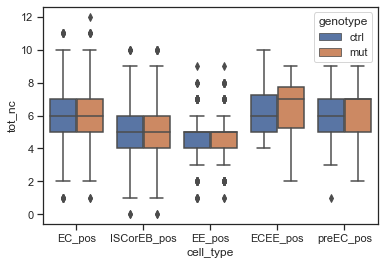

In [ ]:
import seaborn as sns

sns.boxplot(x='cell_type', y='tot_nc', hue='genotype', data=nc_df.reset_index().query('GFP_clone == 0'))